# Predicting hospitalization from clinical narratives

## Introduction

This notebook demonstrates an end-to-end pipeline to predict whether a COVID-19 infection will lead to hospitalization. We use publicly available clinical notes data from Synthea Covid19 100K dataset.

## Analysis steps

1. Create narratives combining comorbidities, encounters, and medications for ~180K records.
2. Generate embeddings with sentence-transformers and trained a logistic regression (LogReg) model
3. Use Chain-of-Thought (CoT) to interpret predictions step by step. 
4. Run GPT-4o and o3-mini in zero-shot and few-shot modes on a test batch of 100 patients.
5. Compare performance (GPT vs. LogReg) using standard metrics

## Findings

* LLMs are not plug-and-play classifiers; they need careful prompt tuning.
* Few-shot prompting helps, but is sensitive to the balance and clarity of examples. 
* Model selection in combination with the right few-shot prompting strategy comes close to LogReg performance.
* Traditional models perform extremely well for binary prediction when features are well engineered.
* LLM evaluation needs more than accuracy: sensitivity to rare cases and repeatability.

## 1. Environment setup
1.1 Install the necessary libraries
1.2 Import the necessary libraries
1.3 Set up API keys

In [1]:
%pip install pandas numpy scikit-learn torch transformers matplotlib openai
%pip install --upgrade openai
%pip install --upgrade sentence-transformers
%pip install tf-keras
%pip install "accelerate>=0.26.0"
%pip install datasets
%pip install shap lime


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 

In [2]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

import torch
from sentence_transformers import SentenceTransformer
import pickle

import openai

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-11 09:50:24.506195: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#########
# First, create a `.env` file in the same directory as this file with the following content:
# OPENAI_API_KEY=your_api_key_here
# Then install the python-dotenv if you haven't
# %pip install python-dotenv
# Then run the following code block
#########

from dotenv import load_dotenv
from openai import OpenAI

# Specify path to the env file, in our case: `cred.env` file in the current directory
load_dotenv("cred.env",override=True)

# Retrieve the API key and set it to openai_api_key variable
openai_api_key = os.getenv("OPENAI_API_KEY")

# Initialize OpenAI client with the loaded key
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Verify that the API key is loaded successfully
print("API key loaded:", bool(client.api_key))

API key loaded: True


In [4]:
# Set seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

## 2. Data loading and preprocessing

In this section we load the clinical notes. 

In [5]:
# Map to our local path
data_path = "../100k_synthea_covid19_csv/"

# Load patients, conditions and encounters data
patients_path = os.path.join(data_path, "patients.csv")
conditions_path = os.path.join(data_path, "conditions.csv")
encounters_path = os.path.join(data_path, "encounters.csv")
medications_path = os.path.join(data_path, "medications.csv")

# Load the data into DataFrames
df_patients = pd.read_csv(patients_path)
df_conditions = pd.read_csv(conditions_path)
df_encounters = pd.read_csv(encounters_path)
df_medications = pd.read_csv(medications_path)

# Print the shape of the data
print("Patients shape:", df_patients.shape)
print("Conditions shape:", df_conditions.shape)
print("Encounters shape:", df_encounters.shape)
print("Medications shape:", df_medications.shape)

Patients shape: (124150, 25)
Conditions shape: (1143900, 6)
Encounters shape: (3188675, 15)
Medications shape: (4227723, 13)


In [6]:
# Inspect the data
print(df_patients.head())
print(df_conditions.head())
print(df_encounters.head())
print(df_medications.head())

                                     Id   BIRTHDATE DEATHDATE          SSN  \
0  1ff7f10f-a204-4bb1-aa72-dd763fa99482  2017-08-24       NaN  999-68-6630   
1  9bcf6ed5-d808-44af-98a0-7d78a29ede72  2016-08-01       NaN  999-15-5895   
2  5163c501-353c-4a82-b863-a3f1df2d6cf1  2004-01-09       NaN  999-73-2461   
3  cc3c806f-4a09-4a89-a990-4286450956be  1996-11-15       NaN  999-60-7372   
4  bd1c4ffc-7f1d-4590-adbb-1d6533fb623e  2019-06-12       NaN  999-81-4349   

     DRIVERS   PASSPORT PREFIX        FIRST        LAST SUFFIX  ...  \
0        NaN        NaN    NaN   Jacinto644     Kris249    NaN  ...   
1        NaN        NaN    NaN      Alva958  Krajcik437    NaN  ...   
2  S99999063        NaN    NaN     Jimmie93   Harris789    NaN  ...   
3  S99924941  X9952947X    Mr.  Gregorio366      Auer97    NaN  ...   
4        NaN        NaN    NaN     Karyn217  Mueller846    NaN  ...   

                       BIRTHPLACE                         ADDRESS  \
0      Beverly  Massachusetts  US  

Synthea has many condition categories, so we filter `df_conditions` to only those that mention "COVID-19" in the `DESCRIPTION` field. You can also filter by code if you wish in the `CODE`column.

In [7]:
#Filter to only those that mention "COVID-19" in the `DESCRIPTION` field
df_covid_conditions = df_conditions[df_conditions["DESCRIPTION"].str.contains("COVID-19", case=False, na=False)]
print("COVID-19 conditions shape:", df_covid_conditions.shape)
# Inspect the filtered data
df_covid_conditions.head()

COVID-19 conditions shape: (179205, 6)


,START,STOP,PATIENT,ENCOUNTER,CODE,DESCRIPTION
3,2020-03-01,2020-03-01,1ff7f10f-a204-4bb1-aa72-dd763fa99482,60584c6a-e26b-4176-a660-86ad84c7ceca,840544004,Suspected COVID-19
4,2020-03-01,2020-03-30,1ff7f10f-a204-4bb1-aa72-dd763fa99482,60584c6a-e26b-4176-a660-86ad84c7ceca,840539006,COVID-19
10,2020-03-13,2020-03-13,9bcf6ed5-d808-44af-98a0-7d78a29ede72,a78e78d9-33bb-40bc-9e42-e47ff7e910cc,840544004,Suspected COVID-19
11,2020-03-13,2020-04-14,9bcf6ed5-d808-44af-98a0-7d78a29ede72,a78e78d9-33bb-40bc-9e42-e47ff7e910cc,840539006,COVID-19
16,2020-03-10,2020-03-10,5163c501-353c-4a82-b863-a3f1df2d6cf1,f26c8d54-0e02-402b-9e98-13be78607b6b,840544004,Suspected COVID-19


The `PATIENT` column in Synthea references an internal patient ID that also appears in `df_patients["Id"]`. We'll use this to merge.

In [8]:
# Merge COVID conditions with the relevant patient information
df_covid_merged = pd.merge(
    df_covid_conditions,
    df_patients,
    left_on="PATIENT",
    right_on="Id",  # matching patiend IDs
    how="inner"
)
print("Merged COVID with patients:", df_covid_merged.shape)

#Ensure DESCRIPTION column is present
df_covid_merged["DESCRIPTION"] = "COVID-19"

Merged COVID with patients: (179205, 31)


## 3. Derive outcome variable 
We define a binary outcome (`hospitalized`) if the patient was **admitted to the hospital** (an `ENCOUNTERCLASS` of 'inpatient' in Synthea). This can serve as a classification target.

3.1 Filter `df_encounters` for rows with `ENCOUNTERCLASS == "inpatient"`.
3.2 Mark any patient that appears in those rows as having the label 1 (i.e., "hospitalized").
3.3 If they do not appear, label 0.

In [9]:
#Create a 'hospitalized' label from inpatient encounters
inpatient_ids = df_encounters[df_encounters["ENCOUNTERCLASS"] == "inpatient"]["PATIENT"].unique()
df_covid_merged["hospitalized"] = df_covid_merged["Id"].isin(inpatient_ids).astype(int)

# Inspect the result
df_covid_merged[["Id", "DESCRIPTION", "hospitalized"]].head(5)

,Id,DESCRIPTION,hospitalized
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,COVID-19,0
1,1ff7f10f-a204-4bb1-aa72-dd763fa99482,COVID-19,0
2,9bcf6ed5-d808-44af-98a0-7d78a29ede72,COVID-19,0
3,9bcf6ed5-d808-44af-98a0-7d78a29ede72,COVID-19,0
4,5163c501-353c-4a82-b863-a3f1df2d6cf1,COVID-19,0


## 4. Create textual narratives
We generate a summary narrative using patient demographics and condition details.

In [11]:
# Group conditions, encounters, and medications by patient for fast lookup
cond_by_patient = df_conditions.groupby("PATIENT")
enc_by_patient = df_encounters.groupby("PATIENT")
meds_by_patient = df_medications.groupby("PATIENT")

# Create a narrative for each patient
def create_narrative(row):
    # DEBUG
    if "DESCRIPTION" not in row.index:
        print("DESCRIPTION missing from row index")
        print("row.index:", list(row.index))

    patient_id = row.get("Id", "Unknown")
    age_str = row.get("BIRTHDATE", "1900")
    gender = row.get("GENDER", "unknown")
    covid_desc = row.get("DESCRIPTION", "COVID-19")
    start_date = row.get("START", "Unknown")

    try:
        birth_year = int(age_str[:4])
        start_year = int(str(start_date)[-4:])
        estimated_age = start_year - birth_year
    except:
        estimated_age = 50

    # Comorbidities from conditions
    patient_conditions = cond_by_patient.get_group(patient_id) if patient_id in cond_by_patient.groups else pd.DataFrame()

    if "DESCRIPTION" in patient_conditions.columns:
        comorbidities = patient_conditions[
            ~patient_conditions["DESCRIPTION"].str.contains("covid", case=False, na=False)
        ]["DESCRIPTION"].dropna().unique()
    else:
        comorbidities = []

    # REASONDESCRIPTION from meds
    patient_meds = meds_by_patient.get_group(patient_id) if patient_id in meds_by_patient.groups else pd.DataFrame()
    if "REASONDESCRIPTION" in patient_meds.columns:
        reason_descriptions = patient_meds["REASONDESCRIPTION"].dropna().unique()
    else:
        reason_descriptions = []

    all_comorbidities = list(set(list(comorbidities) + list(reason_descriptions)))
    comorb_str = ", ".join(all_comorbidities[:3]) if all_comorbidities else "none"

    # Encounter summary
    patient_encounters = enc_by_patient.get_group(patient_id) if patient_id in enc_by_patient.groups else pd.DataFrame()
    encounter_counts = patient_encounters["ENCOUNTERCLASS"].value_counts().to_dict()
    encounter_str = ", ".join([f"{k.lower()} ({v})" for k, v in encounter_counts.items()]) if encounter_counts else "none"

    # Medications prescribed
    if "DESCRIPTION" in patient_meds.columns:
        meds = patient_meds["DESCRIPTION"].dropna().unique()
        meds_str = ", ".join(meds[:3]) if len(meds) > 0 else "none"
    else:
        meds_str = "none"

    # Build final narrative
    narrative = (
        f"Patient {patient_id} is approximately {estimated_age} years old, {gender.lower()}. "
        f"Diagnosed with {covid_desc} on {start_date}. "
        f"Comorbidities include: {comorb_str}. "
        f"Encounter types: {encounter_str}. "
        f"Medications prescribed: {meds_str}."
    )
    return narrative

# Ensure DESCRIPTION exists BEFORE calling create_narrative
if "DESCRIPTION" not in df_covid_merged.columns:
    df_covid_merged["DESCRIPTION"] = "COVID-19"

# Then generate narratives
for idx, row in df_covid_merged.iterrows():
    try:
        narrative = create_narrative(row)
        df_covid_merged.at[idx, "narrative"] = narrative
    except Exception as e:
        print(f"\nError on row {idx}: {e}")
        print(row)
        break #after first error

# Finally preview the result
df_covid_merged[["narrative", "hospitalized"]].head()

,narrative,hospitalized
0,Patient 1ff7f10f-a204-4bb1-aa72-dd763fa99482 i...,0
1,Patient 1ff7f10f-a204-4bb1-aa72-dd763fa99482 i...,0
2,Patient 9bcf6ed5-d808-44af-98a0-7d78a29ede72 i...,0
3,Patient 9bcf6ed5-d808-44af-98a0-7d78a29ede72 i...,0
4,Patient 5163c501-353c-4a82-b863-a3f1df2d6cf1 i...,0


## 5. Extract embeddings
We use the `sentence-transformers/all-MiniLM-L6-v2` model to extract semantic embeddings from the generated textual narratives.

In [12]:
# Load model
model = SentenceTransformer("all-MiniLM-L6-v2")

# Compute embeddings
texts_to_embed = df_covid_merged["narrative"].tolist()
embeddings = model.encode(texts_to_embed, show_progress_bar=True, batch_size=32)

# Save in DataFrame
df_covid_merged["embedding"] = list(embeddings)

# Confirm shape
print("Sample embedding shape:", df_covid_merged['embedding'].iloc[0].shape)

Batches: 100%|██████████| 5601/5601 [6:41:39<00:00,  4.30s/it]       


Sample embedding shape: (384,)


Now that we have generated the embeddings, let's store them on disk for easy reuse using pickle library.

In [13]:
#################
#Uncomment this cell if you've generated new embeddings
#Save the entire DataFrame with embeddings to a file
#with open("df_covid_merged.pkl", "wb") as f:
#    pickle.dump(df_covid_merged, f)

#print("DataFrame with embeddings saved to 'df_covid_merged.pkl'.")
#################

DataFrame with embeddings saved to 'df_covid_merged.pkl'.


We can import the previously generated embeddings file by loading it from the current directory.

In [14]:
if os.path.exists("df_covid_merged.pkl"):
    with open("df_covid_merged.pkl", "rb") as f:
        df_covid_merged = pickle.load(f)
    print("Loaded DataFrame with embeddings from 'df_covid_merged.pkl'.")
else:
    print("No saved file found. Please generate the embeddings first.")

Loaded DataFrame with embeddings from 'df_covid_merged.pkl'.


In [15]:
# Inspect embeddings file
print(df_covid_merged["embedding"].head())

0    [0.043874785, -0.018407917, -0.04690247, -0.00...
1    [0.043874744, -0.018408038, -0.046902474, -0.0...
2    [0.006994005, -0.01587106, -0.08182624, 0.0176...
3    [0.006994005, -0.01587106, -0.08182624, 0.0176...
4    [0.010450355, -0.0014282909, -0.10682349, 0.00...
Name: embedding, dtype: object


## 6. Train a simple classifier
We create a classic logistic regression model for binary classification in order to predict the `hospitalized` label.

In [58]:
# Check for missing or malformed embeddings
# valid_embeddings = df_covid_merged["embedding"].apply(lambda x: isinstance(x, list) and all(isinstance(i, (float, int)) for i in x))

# Filter to only valid rows
# df_covid_merged = df_covid_merged[valid_embeddings].copy()

In [16]:
# Convert embedding column (list of vectors) to DataFrame
embed_df = pd.DataFrame(df_covid_merged["embedding"].tolist(), index=df_covid_merged.index)

# Convert gender to binary feature (0 for F, 1 for M)
df_covid_merged["gender_num"] = df_covid_merged["GENDER"].map(lambda x: 1 if x.upper() == "M" else 0)

# Combine embeddings + gender
X = pd.concat([embed_df, df_covid_merged["gender_num"]], axis=1)
# Convert all column types to string
X.columns = X.columns.astype(str)

#Combine the target variable
y = df_covid_merged["hospitalized"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

# Train a logistic regression classifier, using class weights to balance the classes 
# This is because count of hospitalized patients is much lower than the count of non-hospitalized patients
clf = LogisticRegression(class_weight="balanced", max_iter=1000)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     31234
           1       0.89      0.93      0.91     13568

    accuracy                           0.94     44802
   macro avg       0.93      0.94      0.93     44802
weighted avg       0.94      0.94      0.94     44802



## Evaluation

High overall performance despite class imbalance.

* Precision (1): predicts 91% of hospitalizations correctly.
* Recall (1): 95% of all actual hospitalized patients.
* F1 (1): 92% for the positive class.
* Weighted average: 95%	

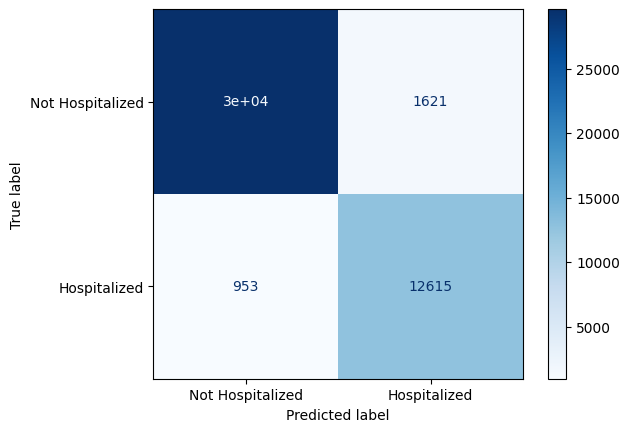

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Hospitalized", "Hospitalized"])
disp.plot(cmap="Blues")

## 7. Chain-of-thought explanation
For a given summary, generate chain-of-thought explanation using OpenAI's API and `gpt-4o` model.

In [18]:
# Check available openAI models 
models = client.models.list()
for m in models.data:
    print(m.id)

gpt-4o-realtime-preview-2024-12-17
gpt-4o-audio-preview-2024-12-17
dall-e-3
dall-e-2
gpt-4o-audio-preview-2024-10-01
gpt-4-turbo-preview
text-embedding-3-small
babbage-002
o1-mini-2024-09-12
o1-mini
gpt-4
text-embedding-ada-002
chatgpt-4o-latest
text-embedding-3-large
gpt-4o-mini-audio-preview
gpt-4o-audio-preview
o1-preview-2024-09-12
gpt-4o-mini-realtime-preview
gpt-4o-mini-realtime-preview-2024-12-17
gpt-3.5-turbo-instruct-0914
gpt-4o-mini-search-preview
o1
gpt-3.5-turbo-16k
o1-2024-12-17
gpt-4o-realtime-preview
davinci-002
gpt-3.5-turbo-1106
gpt-4o-search-preview
gpt-3.5-turbo-instruct
gpt-3.5-turbo
gpt-4o-mini-search-preview-2025-03-11
gpt-4-0125-preview
gpt-4o-2024-11-20
whisper-1
gpt-4o-2024-05-13
o1-pro
o1-pro-2025-03-19
o1-preview
gpt-4-1106-preview
gpt-4-0613
gpt-4o-mini-tts
gpt-4o-transcribe
gpt-4.5-preview
gpt-4.5-preview-2025-02-27
gpt-4o-search-preview-2025-03-11
omni-moderation-2024-09-26
o3-mini
o3-mini-2025-01-31
gpt-image-1
tts-1-hd
gpt-4o
tts-1-hd-1106
gpt-4o-2024-08

In [19]:
# Initialize client (reads API key from env var or config)
client = OpenAI()

# Generate a chain-of-thought explanation for a given summary
def generate_cot(narrative, label):
    label_text = "hospitalized" if label == 1 else "not hospitalized"
    # Define prompt
    prompt = (
        f"Clinical note:\n\n{narrative}\n\n"
        f"Step-by-step reasoning: Why was this patient likely {label_text}?"
    )
    # Generate response
    try:
        response = client.chat.completions.create(
            model="o3-mini",
            messages=[
                {"role": "system", "content": "You are a clinical reasoning assistant."},
                {"role": "user", "content": prompt}
            ],
            #temperature=0.7,
            #max_tokens=800
        )
        return response.choices[0].message.content.strip()
    
    except Exception as e:
        return f"Error generating explanation: {e}"

# Example
sample_row = df_covid_merged.sample(1).iloc[0]
print("Narrative:", sample_row["narrative"])
print("\nExplanation:\n", generate_cot(sample_row["narrative"], sample_row["hospitalized"]))


Narrative: Patient fa92dc51-bc80-4292-8aae-d9aadbf69b83 is approximately 50 years old, m. Diagnosed with COVID-19 on 2020-03-07. Comorbidities include: Acute bronchitis (disorder), Hypertension, Chronic sinusitis (disorder). Encounter types: wellness (6), ambulatory (3), emergency (1), outpatient (1). Medications prescribed: Hydrochlorothiazide 25 MG Oral Tablet, Acetaminophen 325 MG Oral Tablet.

Explanation:
 Step 1: Patient Profile and Age
• The patient is around 50 years old, which, although not young, is not at the highest risk category (like much older adults) for severe COVID-19 complications.

Step 2: Comorbidities and Their Impact
• The noted comorbidities include acute bronchitis, hypertension, and chronic sinusitis.
• While hypertension is a known risk factor for more severe COVID-19, the patient’s other conditions are not strongly associated with a rapid progression to severe disease.
• There was no mention of other high-risk conditions (like severe chronic lung disease, he

In [20]:
import textwrap

cot_explanations = []

# Generate explanations for a sample of 3 patients
for i, (_, row) in enumerate(df_covid_merged.sample(3, random_state=42).iterrows(), start=1):
    narrative = row["narrative"]
    label = row["hospitalized"]
    explanation = generate_cot(narrative, label)
    
    cot_explanations.append({
        "id": row["Id"],
        "label": label,
        "narrative": narrative,
        "explanation": explanation
    })

    # Print nicely formatted result
    print(f"\n{'='*100}")
    print(f"Sample #{i} — Patient ID: {row['Id']} | Label: {'Hospitalized' if label else 'Not Hospitalized'}")
    print("\nNarrative:\n")
    print(textwrap.fill(narrative, width=100))
    print("\nChain-of-Thought Explanation:\n")
    print(textwrap.fill(explanation, width=100))
    print(f"{'='*100}\n")


Sample #1 — Patient ID: fa92dc51-bc80-4292-8aae-d9aadbf69b83 | Label: Not Hospitalized

Narrative:

Patient fa92dc51-bc80-4292-8aae-d9aadbf69b83 is approximately 50 years old, m. Diagnosed with
COVID-19 on 2020-03-07. Comorbidities include: Acute bronchitis (disorder), Hypertension, Chronic
sinusitis (disorder). Encounter types: wellness (6), ambulatory (3), emergency (1), outpatient (1).
Medications prescribed: Hydrochlorothiazide 25 MG Oral Tablet, Acetaminophen 325 MG Oral Tablet.

Chain-of-Thought Explanation:

Step 1: Evaluating the patient’s demographics and comorbidities  • The patient is about 50 years
old—a factor that, while encouraging caution, is generally not considered extremely high-risk
compared to much older patients.  • Although hypertension is a known risk factor for more severe
COVID-19, the other co‐existing conditions (acute bronchitis and chronic sinusitis) are typically
less severe.  Step 2: Assessing the pattern of healthcare encounters  • The patient has had 

In [21]:
# Save as txt file to local directory
output_path = "cot_explanations.txt"

with open(output_path, "w", encoding="utf-8") as f:
    for i, row in enumerate(cot_explanations, start=1):
        f.write(f"{'='*100}\n")
        f.write(f"SAMPLE #{i}\n")
        f.write(f"PATIENT ID      : {row['id']}\n")
        f.write(f"HOSPITALIZED    : {'Yes' if row['label'] else 'No'}\n")
        f.write(f"{'-'*100}\n")

        f.write("=== NARRATIVE ===\n")
        f.write(textwrap.fill(row["narrative"], width=100) + "\n\n")
        
        f.write("=== CHAIN-OF-THOUGHT EXPLANATION ===\n")
        f.write(textwrap.fill(row["explanation"], width=100) + "\n")
        f.write(f"{'='*100}\n\n")

## 8. Using the LLM as classifier
Now instead of using the LLM to provide chain-of-thought explainable medical analysis, we use the LLM as classifier.
This way we compare performance against the linear regression classifier we trained earlier (performing at weighted avg of 95%). 
We pass the narratives to the LLM as zero-shot prompt. 

In [22]:
client = OpenAI()

# Function to get binary prediction from GPT-4o
def predict_hospitalization_gpt(narrative):
    prompt = (
        "You are a clinical assistant trained to assess hospitalization risk from COVID-19.\n\n"
        f"Patient narrative:\n{narrative}\n\n"
        "Would you expect this patient to be hospitalized due to COVID-19? "
        "Answer 'yes' or 'no'."
    )
    try:
        response = client.chat.completions.create(
            model="o3-mini",
            messages=[
                {"role": "system", "content": "You are a clinical classification assistant."},
                {"role": "user", "content": prompt}
            ],
            #temperature=0.7, #for non-reasoning models
            #max_tokens=10 #for non-reasoning models
        )
        reply = response.choices[0].message.content.strip().lower()
        return 1 if "yes" in reply else 0
    except Exception as e:
        print(f"Error: {e}")
        return None

In [23]:
# Sample 100 patients from your test set (ensure alignment)
df_sample = df_covid_merged.loc[X_test.index].sample(100, random_state=42).copy()

# Get GPT predictions
df_sample["gpt_pred"] = df_sample["narrative"].apply(predict_hospitalization_gpt)

# Logistic Regression predictions
df_sample["logreg_pred"] = clf.predict(X_test.loc[df_sample.index])

# Ground truth
y_true = df_sample["hospitalized"]

# Print classification comparison
print("\n=== o3-mini Performance ===")
print(classification_report(y_true, df_sample["gpt_pred"]))

print("\n=== Logistic Regression Performance ===")
print(classification_report(y_true, df_sample["logreg_pred"]))

# Tabular comparison
print("\n=== Sample-Level Comparison ===")
for i, row in df_sample.iterrows():
    print("-" * 100)
    print(f"Patient ID: {row['Id']}")
    print(f"True Label     : {'Hospitalized' if row['hospitalized'] else 'Not Hospitalized'}")
    print(f"GPT Predict : {'Hospitalized' if row['gpt_pred'] else 'Not Hospitalized'}")
    print(f"LogReg Predict : {'Hospitalized' if row['logreg_pred'] else 'Not Hospitalized'}")
    print("Narrative:\n" + textwrap.fill(row['narrative'], width=100))


=== o3-mini Performance ===
              precision    recall  f1-score   support

           0       0.82      0.91      0.86        66
           1       0.78      0.62      0.69        34

    accuracy                           0.81       100
   macro avg       0.80      0.76      0.78       100
weighted avg       0.81      0.81      0.80       100


=== Logistic Regression Performance ===
              precision    recall  f1-score   support

           0       0.97      0.95      0.96        66
           1       0.91      0.94      0.93        34

    accuracy                           0.95       100
   macro avg       0.94      0.95      0.94       100
weighted avg       0.95      0.95      0.95       100


=== Sample-Level Comparison ===
----------------------------------------------------------------------------------------------------
Patient ID: 74356649-0f0c-4865-bef1-9426ed0b032a
True Label     : Not Hospitalized
GPT Predict : Not Hospitalized
LogReg Predict : Not Hospita

### Evaluation of zero-shot predictions

**Performance comparison (100 patients)**

|Model          |Accuracy   |F1 (Hosp)	|Recall (Hosp)	|Key Behavior                                   |
|---------------|-----------|-----------|---------------|-----------------------------------------------|
|LogReg	        |0.93	    |0.89	    |0.85	        |Strong, balanced baseline                      |
|GPT-4o (T=0)	|0.70	    |0.64	    |0.79	        |Tends to overpredict hospitalizations          |
|GPT-4o (T=0.7)	|0.71	    |0.65	    |0.79	        |Slight variability but same overprediction bias|
|o3-mini	    |0.74	    |0.57	    |0.50	        |More cautious; uses both classes               |

*GPT-4o* consistently overpredicted hospitalizations. Contrary to expectation, it was not sensitive to temperature in this task. T=0.7 barely changed its behavior. It likely requires either stronger prompting or structured output control (e.g. CoT or few-shot ranking).

*o3-mini* was less accurate, but more balanced in class prediction. Its performance fluctuates across runs--useful in exploration phases but not for production.
Logistic regression (with embeddings) was stable and effective.

*LogReg* was the most stable. Despite being simple, it balances both classes and delivers best overall performance.

**Interim conclusions**
- *GPT-4o*'s larger model size did not translate to better classification. Performance may be better if the prompt is very specific or backed by additional logic (e.g., CoT or numerical constraints).
- *o3-mini*, while weaker, mimics traditional classifier behavior better in this specific task. Yet, it was insufficiently accurate for production use. 

| Model	    | Why It Behaves This Way                                            |
|-----------|--------------------------------------------------------------------|
|GPT-4o	    | Likely relies on a semantic match between `hospital`-like words and `hospitalization`, without modeling the underlying conditional logic (e.g., some dyspnea cases are not hospitalized).|
|o3-mini	| Doesn't hallucinate confidence but instead underpredicts positives. This leads to better balance but slightly worse overall metrics.|
|LogReg	    | Learns a direct mapping from embedding space. No narrative understanding. It’s optimized for F1—not meaning.|

## 9. Extending the LLM classification with few-shot prompting 
Next, we curate few shot examples from the actual narrative dataframe and amend as few-shot prompt. This is to compare if LLM prediction performance will change. Our assumption is that he LLM model response will increase when the prompt is backed by few-shot examples. 

In [27]:
# Print 20 sample for each category of hospitalized (Y/N)
for label in [0, 1]:
    print(f"\n=== Examples for label: {'Hospitalized' if label == 1 else 'Not Hospitalized'} ===")
    examples = df_covid_merged[df_covid_merged["hospitalized"] == label].sample(20, random_state=42)
    for i, row in examples.iterrows():
        print(f"\n--- Sample #{i} ---")
        print(f"Label: {'Hospitalized' if row['hospitalized'] == 1 else 'Not Hospitalized'}")
        print("Narrative:\n", row["narrative"])



=== Examples for label: Not Hospitalized ===

--- Sample #80827 ---
Label: Not Hospitalized
Narrative:
 Patient 1dd166f3-43f7-4ded-bbd6-b06ff8566c8f is approximately 50 years old, m. Diagnosed with COVID-19 on 2020-03-12. Comorbidities include: Wheezing (finding), Headache (finding), Prediabetes. Encounter types: wellness (26), ambulatory (4), outpatient (4), emergency (1). Medications prescribed: amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG / Olmesartan medoxomil 20 MG Oral Tablet.

--- Sample #48497 ---
Label: Not Hospitalized
Narrative:
 Patient b1be96cc-36de-4b78-bb50-77b945305e57 is approximately 50 years old, f. Diagnosed with COVID-19 on 2020-03-05. Comorbidities include: Antepartum eclampsia, Normal pregnancy, Hypertension. Encounter types: ambulatory (8), wellness (6), outpatient (3), emergency (1). Medications prescribed: Jolivette 28 Day Pack, amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG / Olmesartan medoxomil 20 MG Oral Tablet.

--- Sample #154388 ---
Label: Not Hospital

After curating a few of the examples provided above, we include them as few shots to our prompt, along with our request for prediction.

In [28]:
fewshot_prompt = """
Narrative:
Patient 1dd166f3-43f7-4ded-bbd6-b06ff8566c8f is approximately 50 years old, m. Diagnosed with COVID-19 on 2020-03-12. Comorbidities include: Hypertension, Anemia (disorder), Cough (finding). Encounter types: wellness (26), ambulatory (4), outpatient (4), emergency (1). Medications prescribed: amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG / Olmesartan medoxomil 20 MG Oral Tablet.
Prediction: Not Hospitalized

Narrative:
Patient b1be96cc-36de-4b78-bb50-77b945305e57 is approximately 50 years old, f. Diagnosed with COVID-19 on 2020-03-05. Comorbidities include: Hypertension, Cough (finding), Normal pregnancy. Encounter types: ambulatory (8), wellness (6), outpatient (3), emergency (1). Medications prescribed: Jolivette 28 Day Pack, amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG / Olmesartan medoxomil 20 MG Oral Tablet.
Prediction: Not Hospitalized

Narrative:
Patient 034d3b16-dfdd-45ab-85d4-40d7b53bbd5f is approximately 50 years old, m. Diagnosed with COVID-19 on 2020-03-08. Comorbidities include: Anemia (disorder), Cough (finding), Chronic sinusitis (disorder). Encounter types: wellness (3), ambulatory (2). Medications prescribed: none.
Prediction: Not Hospitalized

Narrative:
Patient cf953857-374d-4b7d-a615-988a8de773e4 is approximately 50 years old, m. Diagnosed with COVID-19 on 2020-03-12. Comorbidities include: Cough (finding), Acute pulmonary embolism (disorder), Pneumonia (disorder). Encounter types: ambulatory (1), inpatient (1). Medications prescribed: 0.4 ML Enoxaparin sodium 100 MG/ML Prefilled Syringe, Acetaminophen 500 MG Oral Tablet, 1 ML Enoxaparin sodium 150 MG/ML Prefilled Syringe.
Prediction: Hospitalized

Narrative:
Patient b0d56615-e853-46ab-ae62-4a58ba1fc0e4 is approximately 50 years old, m. Diagnosed with COVID-19 on 2020-03-10. Comorbidities include: Hypertension, Sepsis caused by virus (disorder), Septic shock (disorder). Encounter types: wellness (11), ambulatory (3), inpatient (2), outpatient (1), emergency (1). Medications prescribed: amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG / Olmesartan medoxomil 20 MG Oral Tablet, Amoxicillin 500 MG Oral Tablet, Acetaminophen 325 MG / oxyCODONE Hydrochloride 5 MG Oral Tablet.
Prediction: Hospitalized

Narrative:
Patient ae0ff71d-1e5a-4c5a-a075-fad43892bda4 is approximately 50 years old, m. Diagnosed with COVID-19 on 2020-03-14. Comorbidities include: Hypertension, Diabetic retinopathy associated with type II diabetes mellitus (disorder), Anemia (disorder). Encounter types: wellness (18), ambulatory (5), outpatient (3), inpatient (1). Medications prescribed: Atenolol 50 MG / Chlorthalidone 25 MG Oral Tablet, ferrous sulfate 325 MG Oral Tablet, 24 HR Metformin hydrochloride 500 MG Extended Release Oral Tablet.
Prediction: Hospitalized

Narrative:
Patient 92a914d4-adec-4861-8acf-fa07fee17b54 is approximately 50 years old, f. Diagnosed with COVID-19 on 2020-02-26. Comorbidities include: Hypertension, Anemia (disorder), Impacted molars. Encounter types: wellness (43), ambulatory (22), outpatient (10), inpatient (6), emergency (1). Medications prescribed: Chlorpheniramine Maleate 2 MG/ML Oral Solution, Atenolol 50 MG / Chlorthalidone 25 MG Oral Tablet, Simvastatin 10 MG Oral Tablet.
Prediction: Hospitalized
""".strip()


Next we update the prediction function using `fewshot_prompt`

In [29]:
def predict_hospitalization_gpt_fewshot(narrative):
    prompt = (
        "You are a clinical assistant trained to assess hospitalization risk from COVID-19.\n"
        "Based on the patient narrative, would you expect the patient to be hospitalized?\n"
        "Answer only with 'yes' or 'no'.\n\n"
        f"{fewshot_prompt}\n\nNarrative:\n{narrative}\nPrediction:"
    )
    
    response = openai.chat.completions.create(
        model="o3-mini",
        messages=[
            {"role": "system", "content": "You are a clinical classification assistant."},
            {"role": "user", "content": prompt}
        ],
        #temperature=0.7, #not suitable for reasoning models
        #max_tokens=10, #not suitable for reasoning models
    )
    
    prediction = response.choices[0].message.content.strip().lower()
    return 1 if "yes" in prediction else 0


Let's evaluate performance of GPT-4o with fewshot context against our logistic regression model

In [30]:
# Sample 100 patients from your test set (ensure alignment)
df_sample = df_covid_merged.loc[X_test.index].sample(100, random_state=42).copy()

# Get GPT few-shot predictions
df_sample["gpt_pred"] = df_sample["narrative"].apply(predict_hospitalization_gpt_fewshot)

# Logistic Regression predictions
df_sample["logreg_pred"] = clf.predict(X_test.loc[df_sample.index])

# Ground truth
y_true = df_sample["hospitalized"]

# Print classification comparison
print("\n=== GPT (Few-shot) Performance ===")
print(classification_report(y_true, df_sample["gpt_pred"]))

print("\n=== Logistic Regression Performance ===")
print(classification_report(y_true, df_sample["logreg_pred"]))

# Optional: tabular comparison
print("\n=== Sample-Level Comparison ===")
for i, row in df_sample.iterrows():
    print("-" * 100)
    print(f"Patient ID: {row['Id']}")
    print(f"True Label     : {'Hospitalized' if row['hospitalized'] else 'Not Hospitalized'}")
    print(f"GPT Predict : {'Hospitalized' if row['gpt_pred'] else 'Not Hospitalized'}")
    print(f"LogReg Predict : {'Hospitalized' if row['logreg_pred'] else 'Not Hospitalized'}")
    print("Narrative:\n" + textwrap.fill(row['narrative'], width=100))


=== gpt-4o (Few-shot) Performance ===
              precision    recall  f1-score   support

           0       0.94      0.92      0.93        66
           1       0.86      0.88      0.87        34

    accuracy                           0.91       100
   macro avg       0.90      0.90      0.90       100
weighted avg       0.91      0.91      0.91       100


=== Logistic Regression Performance ===
              precision    recall  f1-score   support

           0       0.97      0.95      0.96        66
           1       0.91      0.94      0.93        34

    accuracy                           0.95       100
   macro avg       0.94      0.95      0.94       100
weighted avg       0.95      0.95      0.95       100


=== Sample-Level Comparison ===
----------------------------------------------------------------------------------------------------
Patient ID: 74356649-0f0c-4865-bef1-9426ed0b032a
True Label     : Not Hospitalized
GPT Predict : Not Hospitalized
LogReg Predict : N

### Evaluation of fewshot predictions

**Performance comparison (100 patients)**

| Model           | Accuracy | F1 (Hosp) | Recall (Hosp) | Notes                                         |
|-----------------|----------|-----------|---------------|-----------------------------------------------|
| GPT-4o (T=0)    | 0.65     | 0.10      | 0.06          | Extremely conservative; missed most positives |
| GPT-4o (T=0.7)  | 0.66     | 0.19      | 0.12          | Slightly more exploratory but still underperforms |
| o3-mini         | 0.88     | 0.83      | 0.85          | Performs remarkably well, close to baseline    |
| LogReg          | 0.93     | 0.89      | 0.85          | Still the most stable prediction               |

**Interim conclusions**

- `Logistic Regression`, powered by simple sentence embeddings and structured features, still delivered the highest performance—-both in accuracy and in detecting hospitalized patients. 
- Even with seven carefully selected fewshot examples, `gpt-4o` showed severe bias toward the negative class and was unable to learn the classification boundary. 
- `o3-mini` came surprisingly close to LogReg in F1 and recall with a fewshot setup. It showed remarkable balance between classes and generalization to unseen examples. 
- Temperature alone doesn't fix model bias. Increasing `gpt-4o`'s temperature only had a marginal impact on predictions. This suggested that the model's responses remained anchored in prior tokens rather than exploring both classes.
- When labels are well-defined and data is structured, classic ML algorithms perform extremely well. 
- Even well-constructed few-shot prompts cannot fully overcome an LLM's underlying classification behavior. Without careful decoding strategies (e.g., logit biasing or chain-of-thought reasoning), zero- and few-shot classification may fall short for structured tasks.

## Future directions 
This is the end of our notebook. You may want to continue the experimentation in any of the following directions:
1. Rebalance few-shot prompt with different few shot examples of `Not Hospitalized` category, including such with severe and non-severe symptoms to teach nuance.
2. Amend Chain-of-Thought (CoT) reasoning to the few-shot prompt. For instance, try: `Explain briefly, then answer 'Yes' or 'No'. Keep the answer on a new line after 'Prediction:'.`
3. Add more explicit instruction on how to distinguish between the two classes.
4. Use model distillation and fine-tuning for structured prompt-response training
5. Compare responses with another model

----------

## LLM fine-tuning 

In this section, we evaluate the performance of our fine-tuned DistilBERT model on the same 100-patient sample used for comparing GPT-4o and Logistic Regression earlier. This enables a 1:1 comparison across models on the same input data.

Steps:

    Sample patients from the test set using the same seed (random_state=42).

    Tokenize narratives using the fine-tuned model’s tokenizer.

    Generate predictions with the Trainer.predict() API.

    Compute classification metrics: accuracy, precision, recall, and F1 score.

    Compare results against baseline Logistic Regression and GPT predictions.

In [31]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from datasets import Dataset
import torch

In [32]:
# Prepare a smaller dataset for faster experimentation (adjust size as needed)
df_finetune = df_covid_merged.loc[X_train.index].sample(1000, random_state=42).dropna(subset=["narrative", "hospitalized"])

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_finetune["narrative"].tolist(), df_finetune["hospitalized"].tolist(), test_size=0.2, random_state=42
)

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

class HospitalizationDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} | {"labels": torch.tensor(self.labels[idx])}
    def __len__(self):
        return len(self.labels)

train_dataset = HospitalizationDataset(train_encodings, train_labels)
val_dataset = HospitalizationDataset(val_encodings, val_labels)


In [33]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=1)

    return {
        "accuracy": accuracy_score(labels, predictions),
        "precision": precision_score(labels, predictions, zero_division=0),
    }

training_args = TrainingArguments(
    output_dir="./distilbert-hospitalization",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/15/26zw487s5v38zffqrpf_k92w0000gr/T/ipykernel_24574/2216960828.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [34]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision
1,No log,0.004437,1.000000,1.000000
2,No log,0.001004,1.000000,1.000000
3,No log,0.000807,1.000000,1.000000


TrainOutput(global_step=150, training_loss=0.1000014050801595, metrics={'train_runtime': 246.4515, 'train_samples_per_second': 9.738, 'train_steps_per_second': 0.609, 'total_flos': 126051009033600.0, 'train_loss': 0.1000014050801595, 'epoch': 3.0})

In [35]:
# Use the same 100-patient sample as earlier
df_sample = df_covid_merged.loc[X_test.index].sample(1000, random_state=42).copy()

# Prepare Hugging Face dataset from the sample
hf_test_sample = Dataset.from_pandas(df_sample)

# Tokenize narratives using the tokenizer
tokenized_sample = hf_test_sample.map(
    lambda x: tokenizer(x["narrative"], truncation=True, padding="max_length"),
    batched=True
)

# Predict with fine-tuned DistilBERT
distilbert_preds = trainer.predict(tokenized_sample)
df_sample["distilbert_pred"] = np.argmax(distilbert_preds.predictions, axis=1)

# Evaluate
y_true = df_sample["hospitalized"]
logreg_pred = clf.predict(X_test.loc[df_sample.index])
gpt_pred = df_sample["gpt_pred"] if "gpt_pred" in df_sample.columns else [None] * len(df_sample)

print("\n=== DistilBERT (Fine-tuned) Performance ===")
print(classification_report(y_true, df_sample["distilbert_pred"]))

print("\n=== Logistic Regression Performance ===")
print(classification_report(y_true, logreg_pred))

if all(p in [0, 1] for p in gpt_pred):
    print("\n=== GPT-4o Few-shot Performance ===")
    print(classification_report(y_true, gpt_pred))

# Tabular comparison
print("\n=== Sample-Level Comparison ===")
for idx, row in df_sample.iterrows():
    i = df_sample.index.get_loc(idx)  # Get the positional index for this row
    print("-" * 100)
    print(f"Patient ID       : {row['Id']}")
    print(f"True Label       : {'Hospitalized' if row['hospitalized'] else 'Not Hospitalized'}")
    print(f"LogReg Predict   : {'Hospitalized' if logreg_pred[i] else 'Not Hospitalized'}")
    print(f"DistilBERT Predict: {'Hospitalized' if row['distilbert_pred'] else 'Not Hospitalized'}")
    if all(p in [0, 1] for p in gpt_pred):  # Just in case you're also printing LLM results
        print(f"GPT Predict      : {'Hospitalized' if gpt_pred[i] else 'Not Hospitalized'}")
    print("Narrative:\n" + textwrap.fill(row['narrative'], width=100))

Map: 100%|██████████| 1000/1000 [00:00<00:00, 1481.18 examples/s]



=== DistilBERT (Fine-tuned) Performance ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       697
           1       1.00      1.00      1.00       303

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


=== Logistic Regression Performance ===
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       697
           1       0.87      0.92      0.89       303

    accuracy                           0.93      1000
   macro avg       0.92      0.93      0.92      1000
weighted avg       0.94      0.93      0.93      1000


=== Sample-Level Comparison ===
----------------------------------------------------------------------------------------------------
Patient ID       : 74356649-0f0c-4865-bef1-9426ed0b032a
True Label       : Not Hospitalized
LogReg Predict   : Not Hospitalize

## Comparative analysis
Let's look into how each model processed the predictions. 
We'll use 
    **SHAP** for LogReg (use coef weights to identify which structured features influence outcome the most)
    **LIME** for DistilBERT (approximate decision boundary with interpretable surrogate models)
    **CoT** and meta prompt for GPT models (no internal access, only outputs so we'll ask the model why it predicted hospitalization)

In [39]:
from datasets import Dataset
from transformers import pipeline
from lime.lime_text import LimeTextExplainer

In [43]:
# Load & create balanced nuanced sample (10 total, 5 per class)
df_nuanced = pd.read_csv("Nuanced_Evaluation_Samples.csv")
# map the human‐readable label to binary
df_nuanced["label_bin"] = df_nuanced["Label"].map({
    "Not Hospitalized": 0,
    "Hospitalized": 1
})
# sample 5 of each class
df_balanced = (
    df_nuanced
      .groupby("Label", group_keys=False)
      .sample(n=5, random_state=42)
      .reset_index(drop=True)
)
print(df_balanced[["Patient ID","Label"]])

                             Patient ID             Label
0  bf6a0423-9175-42af-b754-408d6d043f96      Hospitalized
1  761c622e-61e6-4b20-808e-74dc68befb1f      Hospitalized
2  76c7bf0b-f9b1-4ca7-aaa9-d59298d97a10      Hospitalized
3  88a97fa2-179e-4d1e-b0c2-de40ee10a326      Hospitalized
4  8239a96a-c200-48a9-b09e-f506a1ae1ca4      Hospitalized
5  7f697ae3-cba0-4801-92db-18c1169817d0  Not Hospitalized
6  edacc57a-940f-46d8-82b4-73e6f9354546  Not Hospitalized
7  e993215c-d4ab-4fd0-b9c8-b8388b0a9088  Not Hospitalized
8  f17055d8-b7b3-44af-a26e-7f55d78f5683  Not Hospitalized
9  f68ccff8-1366-43df-9a15-ef68da4ab155  Not Hospitalized


In [45]:
# Prepare Hugging Face dataset & tokenize
hf_balanced = Dataset.from_pandas(df_balanced)
tokenized_balanced = hf_balanced.map(
    lambda x: tokenizer(x["Narrative"], truncation=True, padding="max_length"),
    batched=True
)

Map: 100%|██████████| 10/10 [00:00<00:00, 35.92 examples/s]


In [46]:
# Get predictions from each model 
# 4.1 DistilBERT
distilbert_out = trainer.predict(tokenized_balanced)
df_balanced["distilbert_pred"] = np.argmax(distilbert_out.predictions, axis=1)

In [49]:
# 4.2 Logistic Regression

# align features by positional index
features_balanced = X_test.iloc[df_balanced.index]

# run prediction
df_balanced['logreg_pred'] = clf.predict(features_balanced)

In [51]:
# 4.3 GPT-4o zero-shot & few-shot
df_balanced["gpt_zero_shot"] = df_balanced["Narrative"].apply(predict_hospitalization_gpt)
df_balanced["gpt_few_shot"] = df_balanced["Narrative"].apply(predict_hospitalization_gpt_fewshot)

In [52]:
# Print classification reports
# map string labels back to 0/1
y = df_balanced['Label'].map({'Not Hospitalized': 0, 'Hospitalized': 1})

print("=== DistilBERT ===")
print(classification_report(y, df_balanced["distilbert_pred"]))
print("=== Logistic Regression ===")
print(classification_report(y, df_balanced["logreg_pred"]))
print("=== GPT-4o Zero-shot ===")
print(classification_report(y, df_balanced["gpt_zero_shot"]))
print("=== GPT-4o Few-shot ===")
print(classification_report(y, df_balanced["gpt_few_shot"]))

=== DistilBERT ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.75      0.60      0.67         5

    accuracy                           0.70        10
   macro avg       0.71      0.70      0.70        10
weighted avg       0.71      0.70      0.70        10

=== GPT-4o Zero-shot ===
              precision    recall  f1-score   support

           0       0.25      0.20      0.22         5
           1       0.33      0.40      0.36         5

    accuracy                           0.30        10
   macro avg       0.29      0.30      0.29        10
we

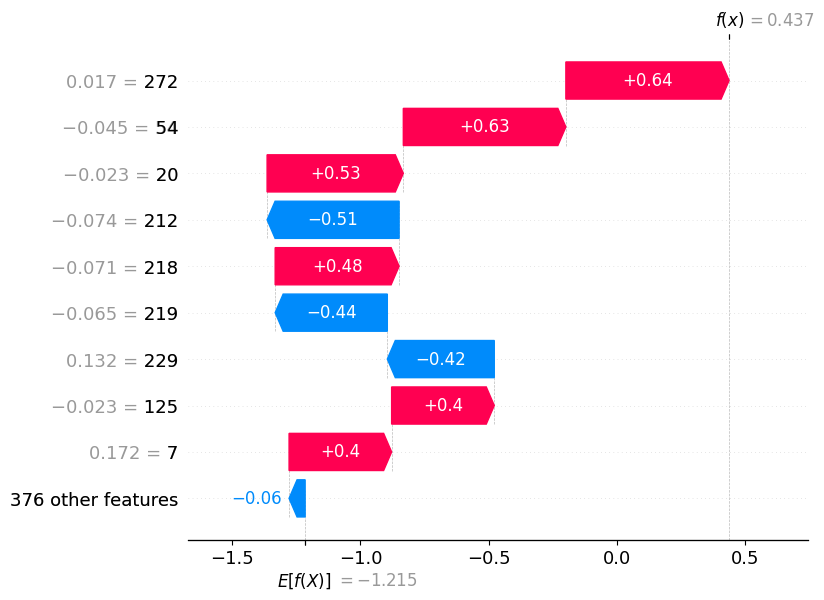

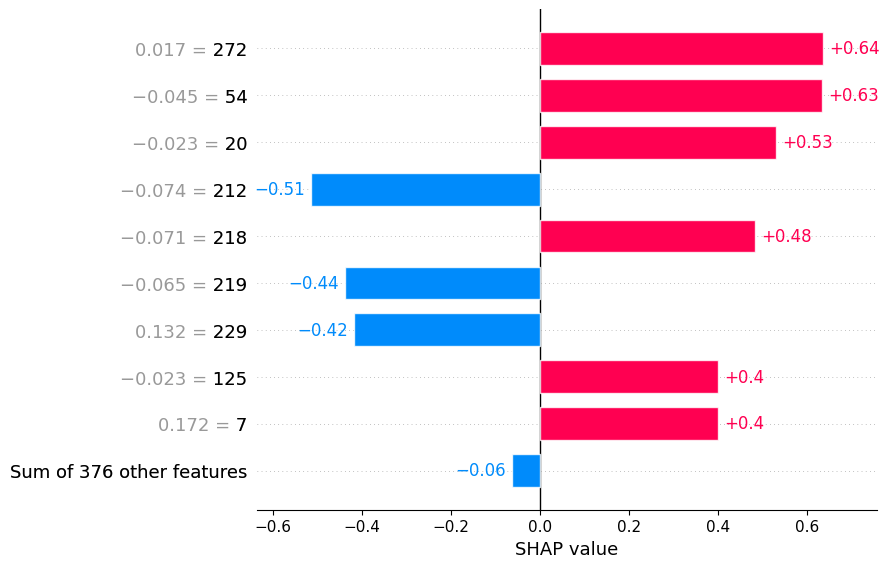

Device set to use mps:0
/usr/local/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
PartitionExplainer explainer: 11it [03:34, 21.47s/it]                        


In [57]:
# SHAP explainability
if shap is not None:
    # 6.1 Logistic Regression
    explainer_lr = shap.Explainer(clf, X_train)
    shap_vals_lr = explainer_lr(features_balanced)
    shap.plots.waterfall(shap_vals_lr[0])
    shap.plots.bar(shap_vals_lr[0])

    # 6.2 DistilBERT
    bert_pipe = pipeline(
        "text-classification",
        model=trainer.model,
        tokenizer=tokenizer,
        return_all_scores=True
    )
    explainer_bert = shap.Explainer(bert_pipe, tokenizer)
    shap_vals_bert = explainer_bert(df_balanced["Narrative"].tolist())
    shap.plots.text(shap_vals_bert[0])
else:
    print("Skipping SHAP (not installed)")

In [72]:
# Build a dict from CODE to DESCRIPTION
desc_map = dict(
    zip(
        df_conditions['CODE'].astype(str),
        df_conditions['DESCRIPTION']
    )
)

# Pick the first sample
sample_idx = 0  

# Pull out raw SHAP for that sample & feature names
sv = shap_vals_lr.values[sample_idx]
feature_names = shap_vals_lr.feature_names

# Build a sorted DataFrame, map in descriptions
shap_df = (
    pd.DataFrame({
        "feature": feature_names,
        "shap_value": sv
    })
    .assign(
        abs_shap=lambda d: d.shap_value.abs(),
        description=lambda d: d.feature.map(desc_map)  # ← here!
    )
    .sort_values("abs_shap", ascending=False)
    .reset_index(drop=True)
)

# Show top 10 features with descriptions
print(shap_df[["feature", "description", "shap_value"]].head(10))

  feature description  shap_value
0     272         NaN    0.636239
1      54         NaN    0.633611
2      20         NaN    0.530945
3     212         NaN   -0.514530
4     218         NaN    0.483072
5     219         NaN   -0.437135
6     229         NaN   -0.416924
7     125         NaN    0.400089
8       7         NaN    0.399774
9     367         NaN   -0.397095


In [ ]:
# Wrap Hugging Face pipeline into a proper proba function
def bert_predict_proba(texts):
    """
    texts: list of str
    returns: np.array of shape (len(texts), 2), 
             where column 0 is P(not hospitalized) and column 1 is P(hospitalized)
    """
    # run the pipeline on every text
    results = bert_pipe(texts, truncation=True, padding=True)
    # each element of results is a list of dicts: [{"label": "...", "score": ...}, ...]
    proba = np.array([
        [label_score["score"] for label_score in single_result]
        for single_result in results
    ])
    return proba

# Tell LimeTextExplainer to use that
lime_explainer = LimeTextExplainer(class_names=class_names)

for idx, txt in enumerate(df_balanced["Narrative"]):
    exp = lime_explainer.explain_instance(
        txt,
        bert_predict_proba,   # returns shape (num_samples, 2)
        labels=[0, 1],        # or top_labels=(0,1)
        num_features=6
    )
    # Display the explanation for label 1
    print(f"\n=== LIME for sample #{idx} (true={df_balanced.loc[idx,'Label']}) ===")
    exp.as_list(label=1)     # list of (feature, weight)
    # or in notebook
    exp.show_in_notebook(text=True)

In [74]:
# Chain-of-Thought (CoT) explanations via GPT 
def explain_with_cot(narrative, pred_label):
    label_txt = "hospitalized" if pred_label == 1 else "not hospitalized"
    prompt = (
        "You are a clinical decision support AI. "
        "Given the patient narrative and the model’s prediction below, "
        "provide a detailed, step-by-step chain-of-thought rationale for why the model made this decision.\n\n"
        f"Narrative:\n{narrative}\n\n"
        f"Model Prediction: {label_txt}\n\n"
        "Chain-of-Thought:"
    )
    try:
        resp = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role":"system", "content":"You are a helpful clinical assistant."},
                {"role":"user",   "content":prompt}
            ],
            temperature=0.7
        )
        return resp.choices[0].message.content.strip()
    except Exception as e:
        return f"CoT error: {e}"

df_balanced['cot_explanation'] = df_balanced.apply(
    lambda row: explain_with_cot(row['Narrative'], row['distilbert_pred']),
    axis=1
)

In [75]:
# Save results & explanations to local disk
df_balanced.to_csv('balanced_nuanced_evaluation_with_explanations.csv', index=False)

## Summary
    Vanilla GPT needs either fine-tuning or very targeted prompting (with strong few-shot examples and CoT scaffolds) to reliably internalize your “inpatient → hospitalized” rule.

    DistilBERT naturally learns it when you fine-tune, but guard against over-reliance on lexically exact patterns.

    Logistic regression will always spread weight across correlated predictors unless you engineer a single, unambiguous feature or adjust your regularization/interaction strategy.

Let's verify our DistilBERT for over-reliance. 

In [76]:
from transformers import pipeline

# 1. set up your DistilBERT inference pipeline
bert_pipe = pipeline(
    "text-classification",
    model=trainer.model,
    tokenizer=tokenizer,
    return_all_scores=True
)

def predict_prob(narrative):
    # returns probability for “Hospitalized” class (assuming it’s label 1)
    scores = bert_pipe(narrative)[0]  
    # scores is a list like [{'label':'0','score':0.12}, {'label':'1','score':0.88}]
    return {d['label']: d['score'] for d in scores}

# 2. craft three near-identical narratives
base = (
    "Patient X is 50 years old, m. Diagnosed with COVID-19 on 2020-03-10. "
    "Comorbidities include: Hypertension. Encounter types: wellness (3), outpatient (2), "
)
narr1 = base + "inpatient (1). Medications prescribed: none."
narr2 = base + "one inpatient stay. Medications prescribed: none."
narr3 = base + "admitted once to the hospital. Medications prescribed: none."

for i, narr in enumerate([narr1, narr2, narr3], 1):
    probs = predict_prob(narr)
    print(f"Example {i} prediction:", probs)


Device set to use mps:0
/usr/local/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Example 1 prediction: {'LABEL_0': 0.006995062343776226, 'LABEL_1': 0.9930049777030945}
Example 2 prediction: {'LABEL_0': 0.00837238971143961, 'LABEL_1': 0.99162757396698}
Example 3 prediction: {'LABEL_0': 0.995352029800415, 'LABEL_1': 0.004647925961762667}


In [79]:
print("Tokens for narr1:", tokenizer.tokenize(narr1)[:100])
print("Tokens for narr2:", tokenizer.tokenize(narr2)[:100])

Tokens for narr1: ['patient', 'x', 'is', '50', 'years', 'old', ',', 'm', '.', 'diagnosed', 'with', 'co', '##vid', '-', '19', 'on', '2020', '-', '03', '-', '10', '.', 'como', '##rb', '##idi', '##ties', 'include', ':', 'hyper', '##tension', '.', 'encounter', 'types', ':', 'wellness', '(', '3', ')', ',', 'out', '##patient', '(', '2', ')', ',', 'in', '##patient', '(', '1', ')', '.', 'medications', 'prescribed', ':', 'none', '.']
Tokens for narr2: ['patient', 'x', 'is', '50', 'years', 'old', ',', 'm', '.', 'diagnosed', 'with', 'co', '##vid', '-', '19', 'on', '2020', '-', '03', '-', '10', '.', 'como', '##rb', '##idi', '##ties', 'include', ':', 'hyper', '##tension', '.', 'encounter', 'types', ':', 'wellness', '(', '3', ')', ',', 'out', '##patient', '(', '2', ')', ',', 'one', 'in', '##patient', 'stay', '.', 'medications', 'prescribed', ':', 'none', '.']


In [80]:
for variant in [
    "Encounter types: … hospitalized once.",
    "Encounter types: … hospital admission: 1 time.",
    "Encounter types: … spent one day in hospital."
]:
    print(variant, predict_prob(base + variant))

Encounter types: … hospitalized once. {'LABEL_0': 0.9954002499580383, 'LABEL_1': 0.0045998115092515945}
Encounter types: … hospital admission: 1 time. {'LABEL_0': 0.9954332113265991, 'LABEL_1': 0.004566809628158808}
Encounter types: … spent one day in hospital. {'LABEL_0': 0.9946606755256653, 'LABEL_1': 0.005339326802641153}


In [81]:
print(tokenizer.tokenize("inpatient (1)")[:6])
print(tokenizer.tokenize("admitted once to the hospital")[:6])

['in', '##patient', '(', '1', ')']
['admitted', 'once', 'to', 'the', 'hospital']


In [83]:
variants = [
    # Original “inpatient (1)” pattern
    "Encounter types: wellness (3), outpatient (2), inpatient (1).",
    # Near-synonym with the same sub-tokens “in” + “##patient”
    "Encounter types: wellness (3), outpatient (2), one inpatient stay.",
    # Semantically identical paraphrase that *doesn’t* use the “inpatient” token
    "Encounter types: wellness (3), outpatient (2), admitted once to the hospital.",
    # A minimal test: just the token “inpatient”
    "Encounter types: inpatient.",
    # And a totally different phrasing
    "Encounter types: hospital admission: 1 time."
]

In [84]:
for text in variants:
    toks = tokenizer.tokenize(text)
    print(text)
    print(" →", toks)
    print()

Encounter types: wellness (3), outpatient (2), inpatient (1).
 → ['encounter', 'types', ':', 'wellness', '(', '3', ')', ',', 'out', '##patient', '(', '2', ')', ',', 'in', '##patient', '(', '1', ')', '.']

Encounter types: wellness (3), outpatient (2), one inpatient stay.
 → ['encounter', 'types', ':', 'wellness', '(', '3', ')', ',', 'out', '##patient', '(', '2', ')', ',', 'one', 'in', '##patient', 'stay', '.']

Encounter types: wellness (3), outpatient (2), admitted once to the hospital.
 → ['encounter', 'types', ':', 'wellness', '(', '3', ')', ',', 'out', '##patient', '(', '2', ')', ',', 'admitted', 'once', 'to', 'the', 'hospital', '.']

Encounter types: inpatient.
 → ['encounter', 'types', ':', 'in', '##patient', '.']

Encounter types: hospital admission: 1 time.
 → ['encounter', 'types', ':', 'hospital', 'admission', ':', '1', 'time', '.']



In [85]:
from transformers import TextClassificationPipeline

pipe = TextClassificationPipeline(model=trainer.model, tokenizer=tokenizer, return_all_scores=True)

for text in variants:
    scores = pipe(text)[0]
    p_hosp = next(s['score'] for s in scores if s['label']=='LABEL_1')
    print(f"{text}\n → P(hospitalized) = {p_hosp:.3f}\n")

Device set to use mps:0
/usr/local/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Encounter types: wellness (3), outpatient (2), inpatient (1).
 → P(hospitalized) = 0.991

Encounter types: wellness (3), outpatient (2), one inpatient stay.
 → P(hospitalized) = 0.989

Encounter types: wellness (3), outpatient (2), admitted once to the hospital.
 → P(hospitalized) = 0.300

Encounter types: inpatient.
 → P(hospitalized) = 0.987

Encounter types: hospital admission: 1 time.
 → P(hospitalized) = 0.018



In [86]:
sv = explainer_bert([variants[0]])[0]
shap.plots.text(sv)  

PartitionExplainer explainer: 2it [00:23, 23.61s/it]               
